In [1]:
from Data_Enrichment import get_features

RAW_DIR = "data/raw"
df_feats, feature_cols = get_features(RAW_DIR)
df_feats = df_feats[(df_feats['season_end_year'] != 2025) & (df_feats['season_end_year'] != 2026)]

/workspaces/Machine-learning/Data_Enrichment.py:300: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ballon_dor_winner"] = df["ballon_dor_winner"].fillna(False).astype(bool)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [3]:
# %% Selected minimal features that explain 94% of the data 
selected_features = ['a_per90_z_lag1', 'matches_played_z_lag1', 'ga_per90_z_lag1',
       'pen_share_z_lag1', 'g_per90_z_lag1', 'g_per90_z_delta',
       'a_per90_w', 'ga_per90_z_delta', 'ga_per90_w', 'g_per90_w',
       'a_per90_z_delta', 'pen_share_w', 'minutes_played_z_delta',
       'minutes_played_z_lag1', 'pen_share_z_delta',
       'main_position', 'age', 'height', 'discipline_rate_z_lag1',
       'position']

# Create dataframe with only selected features
df = df_feats[selected_features].copy()

In [4]:
# %% Separate numeric features and standardize
numeric_features = df.select_dtypes(include=np.number)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_features)

# Quick check
pd.DataFrame(X_scaled, columns=numeric_features.columns).head()


,a_per90_z_lag1,matches_played_z_lag1,ga_per90_z_lag1,pen_share_z_lag1,g_per90_z_lag1,g_per90_z_delta,a_per90_w,ga_per90_z_delta,ga_per90_w,g_per90_w,a_per90_z_delta,pen_share_w,minutes_played_z_delta,minutes_played_z_lag1,pen_share_z_delta,age,height,discipline_rate_z_lag1
0,-0.052447,-0.153307,-0.046583,-0.022538,-0.041101,-0.004802,1.736261,-0.006155,0.789956,0.336199,-0.007497,0.002756,-0.015089,-0.081352,-0.014083,0.749993,-3.579418,-0.045677
1,0.890564,-1.273548,0.335610,-0.263126,0.010564,-0.342989,-0.877991,-0.737110,-0.402963,-0.174502,-1.267641,0.002756,-0.204825,-0.585542,0.000346,0.749993,-3.579418,-0.987343
2,-0.367070,-1.515781,-0.357847,-0.245550,-0.319090,0.034020,-0.877991,0.048273,-0.402963,-0.174502,0.038196,0.002756,-0.023517,-0.790944,-0.013157,0.749993,-3.579418,-1.159286
3,-0.052447,-0.153307,-0.046583,-0.022538,-0.041101,-0.004802,-5.664896,-0.006155,-4.791521,-3.940588,-0.007497,-0.476726,-0.015089,-0.081352,-0.014083,0.970312,0.311271,-0.045677
4,-0.376158,-1.757825,-0.407015,-0.270840,-0.392028,1.968286,-3.216035,1.837438,-1.811657,-1.070244,1.184601,-0.476726,0.412189,-0.937633,-0.007750,0.970312,0.311271,-1.215006


In [5]:
# %% KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=1, n_init=50)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['kmeans_cluster'] = labels.astype(str)


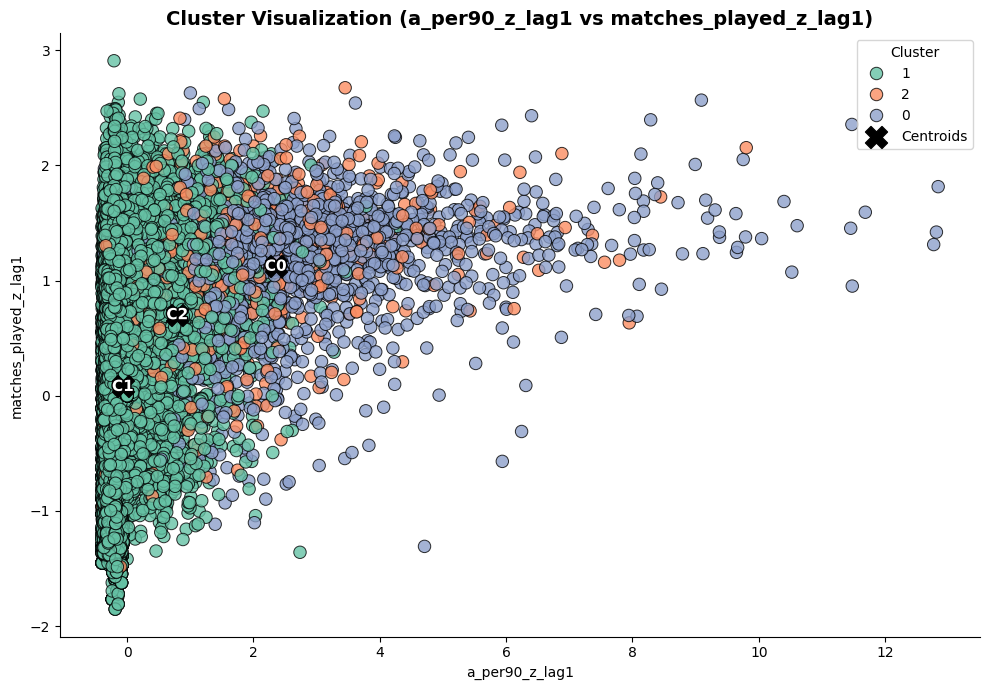

In [10]:
# %% Professional Cluster Plot (without PCA)
import matplotlib.patheffects as path_effects

# Choose two variables to plot (can be changed)
x_var = "a_per90_z_lag1"
y_var = "matches_played_z_lag1"

plt.figure(figsize=(10, 7))
palette = sns.color_palette("Set2", n_colors=df['kmeans_cluster'].nunique())

sns.scatterplot(
    data=df,
    x=x_var, y=y_var,
    hue='kmeans_cluster',
    palette=palette,
    s=80, edgecolor='black', alpha=0.8
)

# Optional centroids (using original variables)
centroids = df.groupby('kmeans_cluster')[[x_var, y_var]].mean()
plt.scatter(
    centroids[x_var], centroids[y_var],
    c='black', s=250, marker='X', label='Centroids'
)

for i, (x, y) in enumerate(zip(centroids[x_var], centroids[y_var])):
    txt = plt.text(x, y, f'C{i}', fontsize=11, weight='bold', color='white',
                   ha='center', va='center')
    txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])

plt.title(f'Cluster Visualization ({x_var} vs {y_var})', fontsize=14, weight='bold')
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.legend(title='Cluster')
sns.despine()
plt.tight_layout()
plt.show()


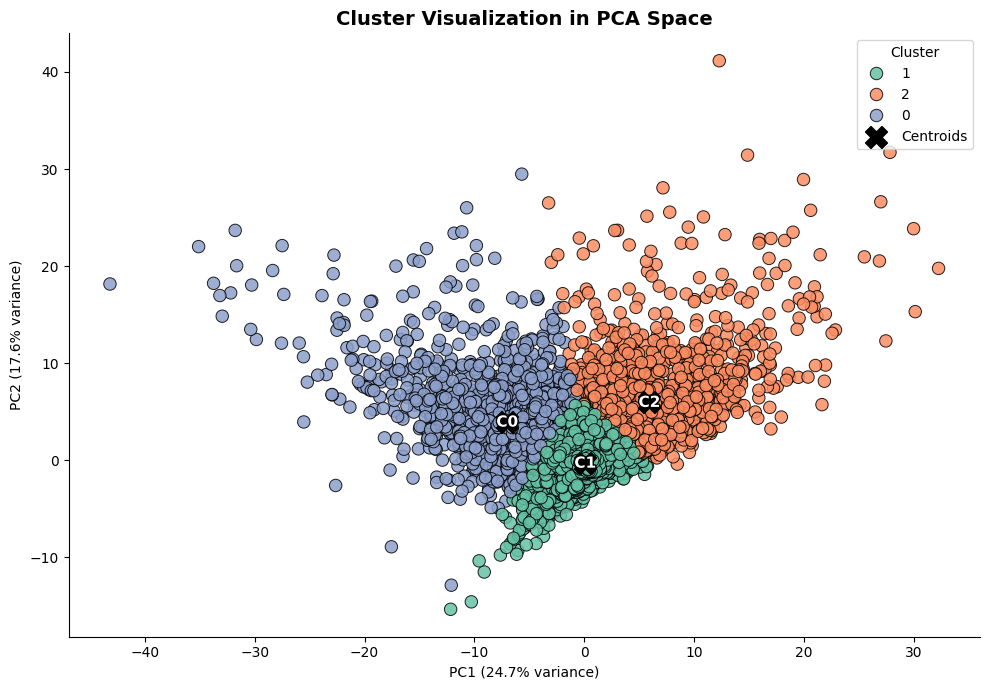

In [7]:
# %% Professional Cluster Plot (with PCA)
from sklearn.decomposition import PCA

# --- PCA projection for visualization ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'Cluster': df['kmeans_cluster']
})

# --- Plot ---
plt.figure(figsize=(10, 7))
palette = sns.color_palette("Set2", n_colors=df['kmeans_cluster'].nunique())

sns.scatterplot(
    data=df_pca,
    x='PC1', y='PC2',
    hue='Cluster',
    palette=palette,
    s=80, edgecolor='black', alpha=0.85
)

# --- Cluster centroids in PCA space ---
centroids_pca = pd.DataFrame(pca.transform(kmeans.cluster_centers_), columns=['PC1', 'PC2'])
plt.scatter(
    centroids_pca['PC1'], centroids_pca['PC2'],
    c='black', s=250, marker='X', label='Centroids'
)

for i, (x, y) in enumerate(zip(centroids_pca['PC1'], centroids_pca['PC2'])):
    txt = plt.text(x, y, f'C{i}', fontsize=11, weight='bold', color='white',
                   ha='center', va='center')
    txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])

plt.title('Cluster Visualization in PCA Space', fontsize=14, weight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.legend(title='Cluster')
sns.despine()
plt.tight_layout()
plt.show()


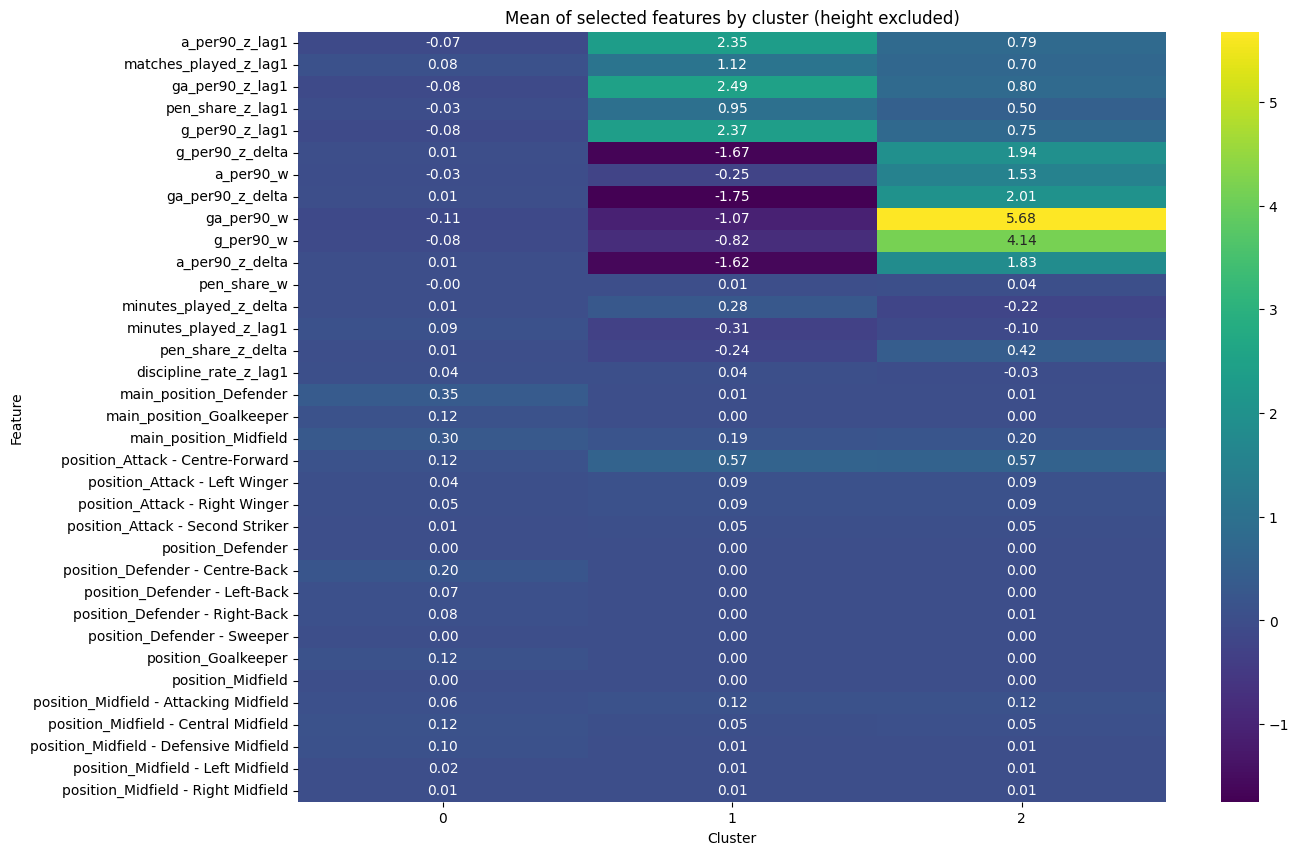

In [7]:
# %% Module 6 – Cluster Analysis (fixed, height removed)

# Exclude 'height' from numeric features
features_for_analysis = [f for f in df.columns if f != 'height' and f != 'kmeans_cluster' and f!= "age"]

# Encode categorical features
categorical_cols = ['main_position', 'position']
categorical_cols = [col for col in categorical_cols if col in features_for_analysis]

df_encoded = pd.get_dummies(df[features_for_analysis + ['kmeans_cluster']], 
                            columns=categorical_cols, drop_first=True)

# Compute cluster means (numeric + encoded categorical)
cluster_means = df_encoded.groupby('kmeans_cluster').mean().T

# Heatmap of features by cluster
plt.figure(figsize=(14, 10))
sns.heatmap(cluster_means, annot=True, cmap='viridis', fmt=".2f")
plt.title('Mean of selected features by cluster (height excluded)')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()



/tmp/ipykernel_2104/2095024836.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y=var, data=df, palette='Set3')


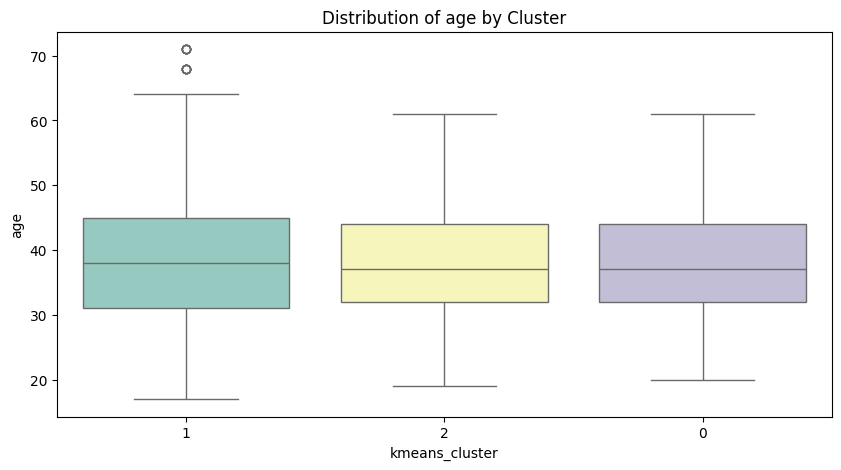

/tmp/ipykernel_2104/2095024836.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y=var, data=df, palette='Set3')


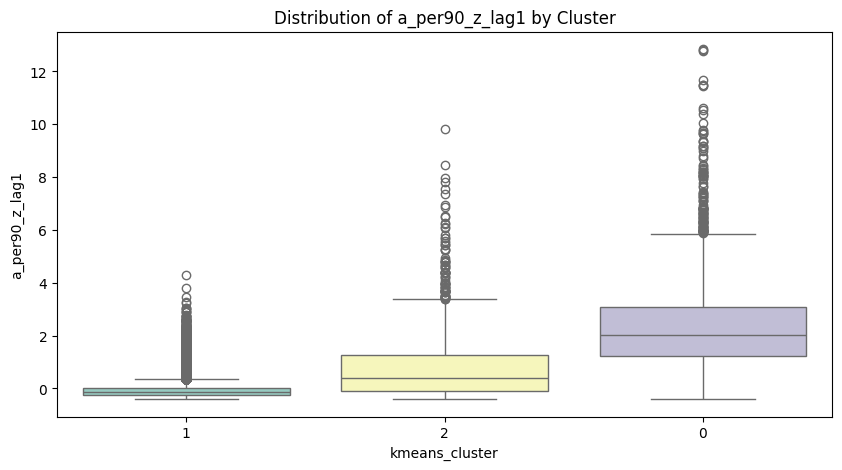

/tmp/ipykernel_2104/2095024836.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y=var, data=df, palette='Set3')


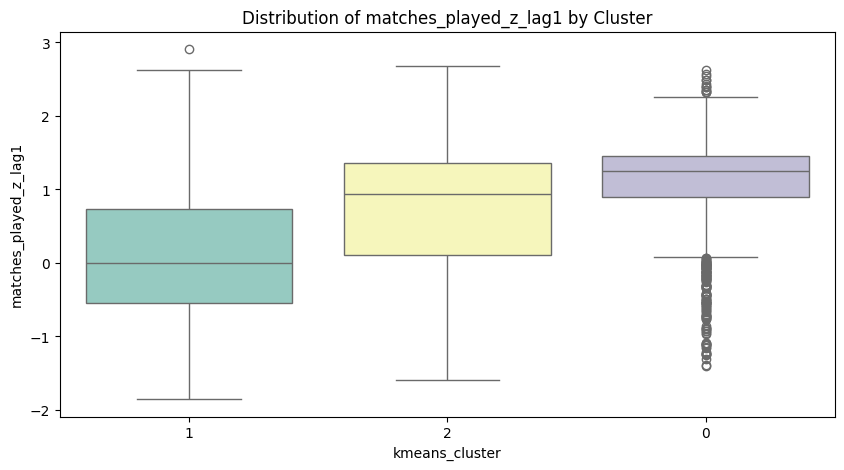

/tmp/ipykernel_2104/2095024836.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y=var, data=df, palette='Set3')


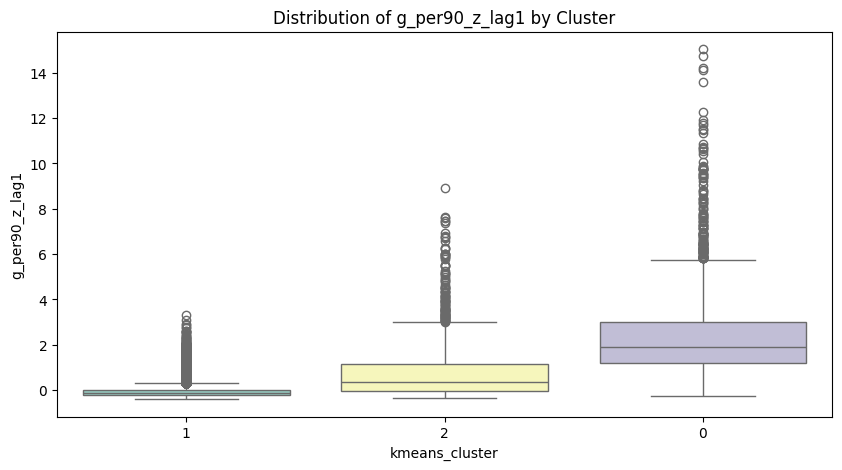

/tmp/ipykernel_2104/2095024836.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y=var, data=df, palette='Set3')


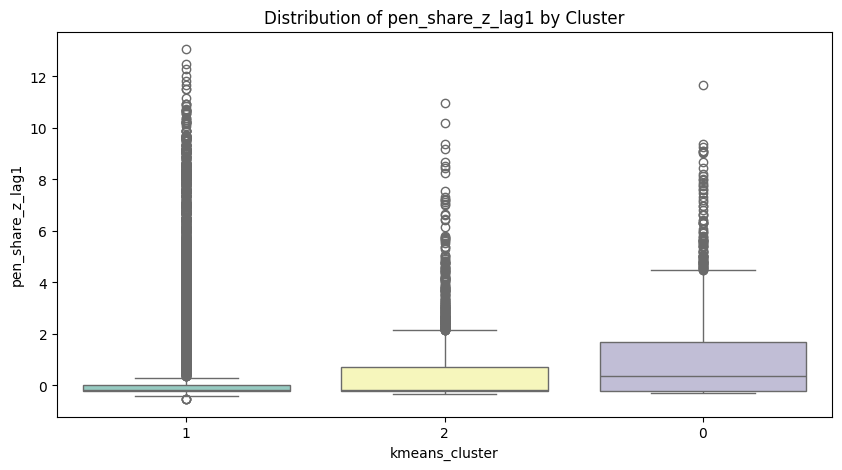

In [11]:
variables = ["age", "a_per90_z_lag1", "matches_played_z_lag1", "g_per90_z_lag1", "pen_share_z_lag1"]

for var in variables:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='kmeans_cluster', y=var, data=df, palette='Set3')
    plt.title(f'Distribution of {var} by Cluster')
    plt.show()


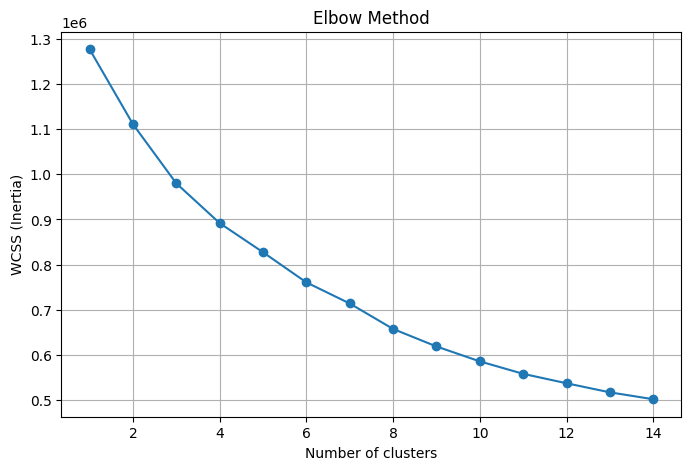

In [9]:
# %% Elbow method
wcss = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()


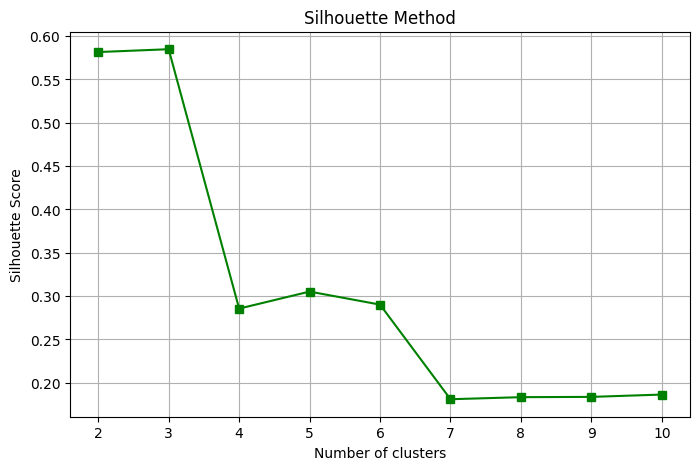

In [10]:
# %% Silhouette method
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, marker='s', color='green')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()
